# Quickstart

This is a notebook explaining the usage of the main features of `mobilkit`.

The features covered here are:

- how to create a synthetic dataset from the Microsoft's [GeoLife](https://www.microsoft.com/en-us/download/details.aspx?id=52367&from=https%3A%2F%2Fresearch.microsoft.com%2Fen-us%2Fdownloads%2Fb16d359d-d164-469e-9fd4-daa38f2b2e13%2F) dataset.
- how to create a tessellation shapefile in case you only have a collection of centroid;
- load data from a `pandas` dataframe;
- tessellate the pings (assign them to a given location);
- compute the land use of an urban area;
- compute the resident population for each area and compare it with census figures;
- compute user activity statistics and filter users accordingly;
- compute the displacement figures in a given area.

To allow the publication of the data we used an open dataset such as the GeoLife one.
We augment the number of users observed by using some functions present in the `mobilkit.loader` module.

Depending on the case we map each user/day or each user/week to a synthetic user performing the same events as in the original dataset at the same original time, just traslating everything in the synthetic day or week..

To continue you have to download the [GeoLife](https://www.microsoft.com/en-us/download/details.aspx?id=52367&from=https%3A%2F%2Fresearch.microsoft.com%2Fen-us%2Fdownloads%2Fb16d359d-d164-469e-9fd4-daa38f2b2e13%2F) dataset and uncompress it in the `data` directory.

In [1]:
%config Completer.use_jedi = False
%matplotlib inline

import pytz
from datetime import datetime
import geopandas as gpd

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import mobilkit
from dask.distributed import Client
from shapely.geometry import Polygon, Point
from dask import dataframe as dd

import warnings
warnings.filterwarnings('ignore')

import mobilkit

## Create tessellation from points

I use the file with centroids found [here](https://www.beijingcitylab.com/app/download/12184598199/DT19_v2.zip?t=1644650253), select some points in Beijing and create a Voronoi tessellation of it.

In [2]:
# Choose the spatial extent of your analysis and where to save the Vortonoi tessellation
box = (116.20, 39.74, 116.56, 40.06)
voronoi_file = "../../data/Beijing/voronoi_points_beijing.shp"

df_china = gpd.read_file("../../data/Beijing/DT19new/PopCensus2010_township.shp")
if not os.path.exists(voronoi_file):
    poly_box = mobilkit.spatial.box2poly(box)
    df_china = df_china[df_china.within(poly_box)]
    poly_gdf = gpd.GeoDataFrame(["Region"], geometry=[poly_box], crs=df_china.crs)
    layer = mobilkit.spatial.makeVoronoi(df_china)
    layer.to_file(voronoi_file)
else:
    layer = gpd.read_file(voronoi_file)
    box = layer.unary_union.bounds
    poly_box = mobilkit.spatial.box2poly(box)
    df_china = df_china[df_china.within(poly_box)]

<Axes: >

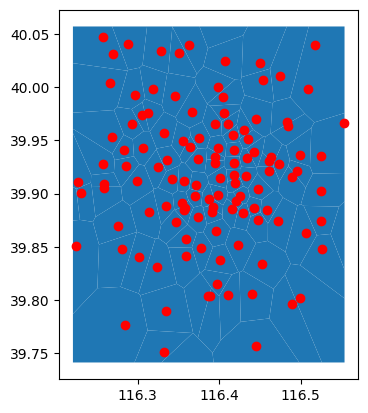

In [3]:
ax = layer.plot()
df_china.plot(color="r", ax=ax)

## Load/reload the geolife trajectories data

You should manually download the data from [here](https://www.microsoft.com/en-us/download/details.aspx?id=52367&from=https%3A%2F%2Fresearch.microsoft.com%2Fen-us%2Fdownloads%2Fb16d359d-d164-469e-9fd4-daa38f2b2e13%2F) and put them into to `data/` folder and unzip them there.

```
cd ../data/
wget https://download.microsoft.com/download/F/4/8/F4894AA5-FDBC-481E-9285-D5F8C4C4F039/Geolife%20Trajectories%201.3.zip
unzip Geolife%20Trajectories%201.3.zip
```

In [4]:
# !wget -P ../../data/ https://download.microsoft.com/download/F/4/8/F4894AA5-FDBC-481E-9285-D5F8C4C4F039/Geolife%20Trajectories%201.3.zip
# !unzip -d ../../data/ ../../data/Geolife\ Trajectories\ 1.3.zip

In [5]:
geolifePath = "../../data/Geolife Trajectories 1.3"
pkl_trajectories = "../../data/Geolife Trajectories 1.3/processed_traj.pkl"
if not os.path.exists(pkl_trajectories):
    df_geolife = mobilkit.loader.loadGeolifeData(geolifePath)
    df_geolife.to_pickle(pkl_trajectories)
else:
    df_geolife = pd.read_pickle(pkl_trajectories)
    
df_geolife.head()

,UTC,acc,datetime,lat,lng,uid
0,1224730384,1,2008-10-23 10:53:04+08:00,39.984702,116.318417,0
1,1224730390,1,2008-10-23 10:53:10+08:00,39.984683,116.318450,0
2,1224730395,1,2008-10-23 10:53:15+08:00,39.984686,116.318417,0
3,1224730400,1,2008-10-23 10:53:20+08:00,39.984688,116.318385,0
4,1224730405,1,2008-10-23 10:53:25+08:00,39.984655,116.318263,0


## Create synthetic days/week from the data

We perform two expansion of the data:
- a weekly one, where each (user,week) couple is treated as a separate user and all the events are moved to a synthetic week keeping the original weekday, hour, minute and second of the recorded point;
- a daily one, where each (user,day) couple is treated as a separate user and all the events are moved to a synthetic day keeping the original hour, minute and second of the recorded point;

In [6]:
# One day with all the data projected to a single day
selected_day = datetime(2020, 6, 1, tzinfo=pytz.timezone("UTC"))
df_users_day = mobilkit.loader.syntheticGeoLifeDay(df_geolife, selected_day=selected_day)
df_users_day["uid"].nunique()

11152

In [7]:
# One week with all the data projected to a single week
selected_week = datetime(2020, 6, 4, tzinfo=pytz.timezone("UTC"))
df_users_week = mobilkit.loader.syntheticGeoLifeWeek(df_geolife, selected_week=selected_week)
df_users_week["uid"].nunique()

Anticipated the date to Monday:  2020-06-01 00:00:00+00:00


2524

We now have two dataframes containing our data.

Each row is an event containing the spatial and temporal information.

In [8]:
df_users_week.head(4)

,UTC,acc,datetime,lat,lng,uid
0,1591267984,1,2020-06-04 10:53:04+00:00,39.984702,116.318417,0
1,1591267990,1,2020-06-04 10:53:10+00:00,39.984683,116.318450,0
2,1591267995,1,2020-06-04 10:53:15+00:00,39.984686,116.318417,0
3,1591268000,1,2020-06-04 10:53:20+00:00,39.984688,116.318385,0


(39.74096801500008, 40.05733690900007)

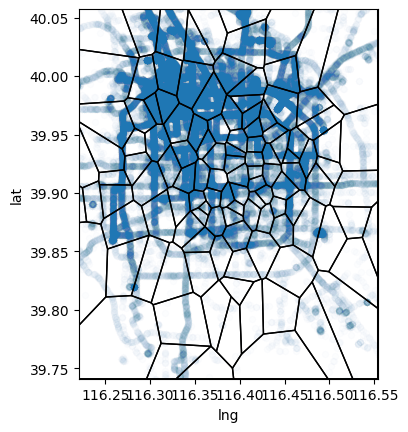

In [9]:
# Get a small fraction of the pings and see how they are distributed over the tessellation
ax = df_users_day.sample(frac=.01).plot("lng","lat",kind="scatter", alpha=.01)
ax = layer.plot(color="none", edgecolor="k", ax=ax)

box = layer.unary_union.bounds
plt.xlim(box[0], box[2])
plt.ylim(box[1], box[3])

## Create dask client
Launch worker and scheduler if working on localhost with:
```
dask-worker 127.0.0.1:8786 --nworkers -1 & dask-scheduler
```
If you get an error with `Popen` in `dask-worker`, add the option `--preload-nanny multiprocessing.popen_spawn_posix` to the first command.

In [10]:
client = Client(address="127.0.0.1:8786")
client

<Client: 'tcp://192.168.1.20:8786' processes=48 threads=48, memory=188.55 GiB>

## Load events in dask

Here we use the `dask` API, see the `loader` module on how to load pings from raw files.

In [11]:
dd_users_raw = dd.from_pandas(df_users_day, npartitions=20)
dd_week_raw = dd.from_pandas(df_users_week, npartitions=20)

## Compute user stats

We first focus on the weekly dataframe because it has more than one day (but less users).

We show here how to compute the basic user stats.

You can see the `mobilkit.stats.userStats` documentation for details but we get back some basic stats for each user.

In [12]:
# Use the .compute() to make it a pandas df
users_stats_df = mobilkit.stats.userStats(dd_week_raw).compute()
users_stats_df.head(4)

,uid,min_day,max_day,pings,daysActive,daysSpanned,pingsPerDay,avg
0,82,2020-06-01 00:00:00+00:00,2020-06-07 00:00:00+00:00,14027,7,6,"[779, 1814, 790, 1848, 852, 2096, 5848]",2003.857143
1,102,2020-06-01 00:00:00+00:00,2020-06-07 00:00:00+00:00,16598,7,6,"[641, 2493, 3853, 1181, 2695, 2251, 3484]",2371.142857
2,111,2020-06-01 00:00:00+00:00,2020-06-07 00:00:00+00:00,11562,7,6,"[1165, 1124, 1038, 1001, 2203, 1453, 3578]",1651.714286
3,141,2020-06-03 00:00:00+00:00,2020-06-06 00:00:00+00:00,3909,3,3,"[218, 932, 2759]",1303.000000


<Axes: title={'center': 'ul: 40 - ur: 2180 - lr: 233 - ll: 71'}, xlabel='log10 #records', ylabel='timespan (days daysActive)'>

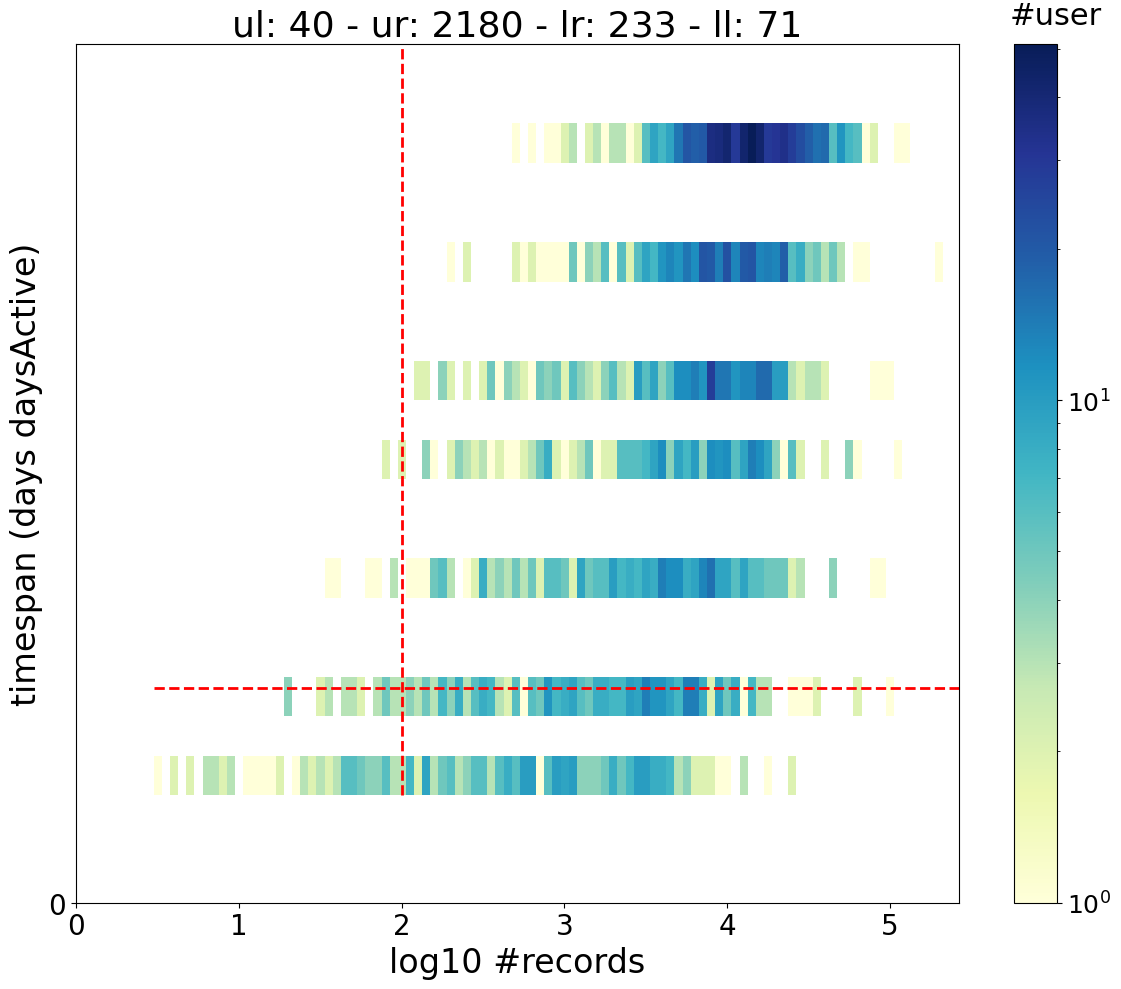

In [13]:
# We can plot the distribution of the number of pings and active days to see how many users we have in each quadrant
mobilkit.stats.plotUsersHist(users_stats_df, min_pings=100, min_days=2)

## Filter users based on stats

We want to keep only users with at least 2 active days and 100 pings.

In [14]:
# We either provide users filtering by hand
valid_users = list(users_stats_df.query("daysActive >= 2 & pings > 100")["uid"])
df_filtered = mobilkit.stats.filterUsersFromSet(dd_week_raw, users_set=valid_users)

In [15]:
# Or we could have had the stats and filter computed at once
df_filtered, users_stats_df, valid_users = mobilkit.stats.filterUsers(dd_week_raw, minPings=100, minDaysActive=2)

## Assign pings to an area

We first assign each ping to a given area passing the name of the shapefile to use.

With `filterAreas=True` we are discarding all the events that fall outside of our ROI.

In [16]:
dd_week_with_zones, tessellation_gdf = mobilkit.spatial.tessellate(df_filtered,
                                                                   tesselation_shp=voronoi_file,
                                                                   filterAreas=True)

## Compute home and work areas

Once we have each ping assigned to a given area, we can sort out the home and work areas of each user by looking where he spends most of the time during day and night-time.

We first add the `isHome` and `isWork` columns, then we pass this df to the home location function to see where an agent lives.

---
**NOTE**

When determining the home location of a user, please consider that some data providers, like _Cuebiq_, obfuscate/obscure/alter the coordinates of the points falling near the user's home location in order to preserve privacy.

This means that you cannot locate the precise home of a user with a spatial resolution higher than the one used to obfuscate these data. If you are interested in the census area (or geohash) of the user's home alone and you are using a spatial tessellation with a spatial resolution wider than or equal to the one used to obfuscate the data, then this is of no concern.

However, tasks such as stop-detection or POI visit rate computation may be affected by the noise added to data in the user's home location area. Please check if your data has such noise added and choose the spatial tessellation according to your use case.

---

In [17]:
# Add the home/work columns, all the events within the given hours will be considered home/work
dd_week_hw = mobilkit.stats.userHomeWork(dd_week_with_zones,
                                         homeHours=(20, 8),
                                         workHours=(9,18))

In [18]:
# Compute the locations and pass them to pandas:
# - the tile_IDs of the areas of home and work;
# - the lat and lon of the home and work locations;
df_hw_locs = mobilkit.stats.userHomeWorkLocation(dd_week_hw)
df_hw_locs_pd = df_hw_locs.compute()

### The synthetic case
We now merge our population estimate with the one given in the original shapefile in the `POP` column.

Results are not beautiful but remember that:
- we are working on a small dataset (~200 original users) expanded to simulate many users in an arbitrary way;
- the spatial tessellation may be different from the original one as we reconstructed it with a Voronoi tessellation;

While we focus on the Beijing synthetic case here, in the next section we will show the estimations for the Mexico usecase, where results are found to be in very good agreement with the empirical case.

In [19]:
df_hw_locs_pd.head(4)

,tot_pings,home_tile_ID,lat_home,lng_home,home_pings,work_tile_ID,lat_work,lng_work,work_pings
uid,,,,,,,,,
82,4297.0,106.0,40.004416,116.322909,1218.0,106.0,39.997723,116.323012,1040.0
102,16531.0,106.0,39.996643,116.325115,2471.0,106.0,40.000683,116.323300,1966.0
111,11562.0,106.0,40.000315,116.322960,2240.0,106.0,40.001965,116.322623,3066.0
141,2200.0,102.0,39.981531,116.338790,78.0,89.0,39.967705,116.339616,522.0


In [20]:
population_per_area = df_hw_locs_pd.reset_index().groupby("home_tile_ID").agg({
                                                "uid": "nunique",
                                                "home_pings": "sum"}).reset_index()

population_per_area = population_per_area.rename(columns={
                                                "home_tile_ID": "tile_ID",
                                                "uid": "POP_DATA",
                                                "home_pings": "pings"})
population_per_area.head(2)

,tile_ID,POP_DATA,pings
0,0.0,6,1498.0
1,2.0,1,0.0


In [21]:
# Merge with gdf
gdf_areas = pd.merge(tessellation_gdf, population_per_area, on="tile_ID", how="left")
gdf_areas["POP_DATA"] = gdf_areas["POP_DATA"].fillna(0)
gdf_areas.head(4)

,TID,POP,M,F,AGE0,AGE15,AGE65,Address,geometry,tile_ID,POP_DATA,pings
0,257,102402,51818,50584,11322,83441,7639,北京市大兴区清源街道,"POLYGON ((116.29603 39.74097, 116.31217 39.771...",0,6.0,1498.0
1,259,168444,94211,74233,17898,144834,5712,北京市大兴区黄村,"POLYGON ((116.22050 39.74097, 116.22050 39.786...",1,0.0,NaN
2,262,49612,27649,21963,4472,42847,2293,北京市大兴区瀛海,"POLYGON ((116.39314 39.74097, 116.39185 39.750...",2,1.0,0.0
3,92,48076,24392,23684,4975,39191,3910,北京市丰台区南苑街道,"POLYGON ((116.39185 39.75000, 116.37391 39.764...",3,2.0,0.0


Text(24.625000000000007, 0.5, 'Data population')

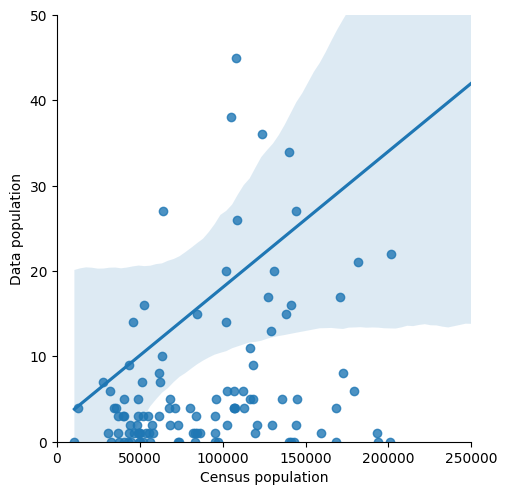

In [22]:
sns.lmplot(x="POP", y="POP_DATA", data=gdf_areas)
# plt.loglog()
plt.xlim(0, 250000)
plt.ylim(0, 50)

plt.xlabel("Census population")
plt.ylabel("Data population")

### The Mexican case

We load the results of the population analysis in Mexico for the Puebla earthquake and see the agreement between census and mobility estimation at different aggregation levels, from the smallest (AGEB, street blocks) to the largest (Municipios, city level).

**Note that these data are not included in the repository to preserve users' privacy.**

This section is inserted as an example to show the capabilities of the mobility data to measure the population spatial density.

In [24]:
# Table-preview not shown so as not to disclose original dataset statistics
population_mexico_df = pd.read_csv("../../data/population_estimate_mexico.csv")
population_mexico_df.head(2)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     352.2
Date:                Wed, 02 Jun 2021   Prob (F-statistic):           1.25e-75
Time:                        08:16:16   Log-Likelihood:                -208.40
No. Observations:                4369   AIC:                             420.8
Df Residuals:                    4367   BIC:                             433.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5443      0.042    -13.058      0.0

(0.1, 100.0)

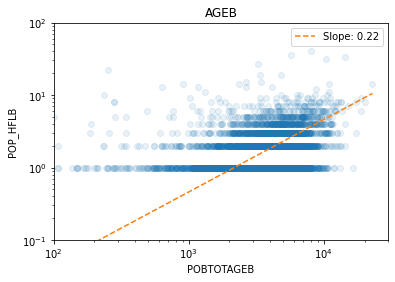

In [25]:
# The smallest aggregations (street block level)
mobilkit.viz.plot_pop(population_mexico_df, "AGEB")
plt.xlim(1e2, 3e4)
plt.ylim(1e-1, 1e2)

In [26]:
# Aggregate to locality (districts) and municipio (city)
population_mexico_df["CVEGEO_LOC"] = population_mexico_df["CVEGEO"].apply(lambda s: s[:-4])
population_mexico_df["CVEGEO_MUN"] = population_mexico_df["CVEGEO_LOC"].apply(lambda s: s[:-4])

urban_areas_loc_gdf = population_mexico_df.groupby("CVEGEO_LOC").agg({
        "POP_HFLB": "sum",
        "POBTOT": "sum",
        "CVEGEO_MUN": "first",
        "CVE_LOC": "first",
        "CVE_ENT": "first",
        "CVE_MUN": "first",
    }).reset_index()

urban_areas_mun_gdf = population_mexico_df.groupby("CVEGEO_MUN").agg({
        "POP_HFLB": "sum",
        "POBTOT": "sum",
        "CVE_ENT": "first",
        "CVE_MUN": "first",
    }).reset_index()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     1535.
Date:                Wed, 02 Jun 2021   Prob (F-statistic):          7.01e-150
Time:                        08:16:24   Log-Likelihood:                -113.13
No. Observations:                 470   AIC:                             230.3
Df Residuals:                     468   BIC:                             238.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3410      0.098    -34.198      0.0

(0.7, 8000.0)

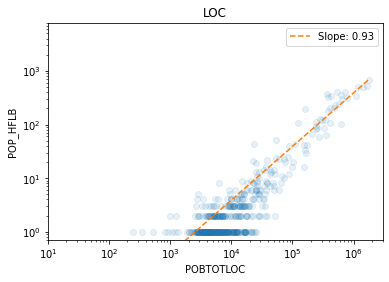

In [27]:
# The locality aggregation level (district level)
mobilkit.viz.plot_pop(urban_areas_loc_gdf, "LOC")
plt.xlim(1e1,3e6)
plt.ylim(7e-1,8e3)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     1214.
Date:                Wed, 02 Jun 2021   Prob (F-statistic):           8.83e-89
Time:                        08:16:25   Log-Likelihood:                -52.923
No. Observations:                 210   AIC:                             109.8
Df Residuals:                     208   BIC:                             116.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.5717      0.156    -29.313      0.0

(0.7, 8000.0)

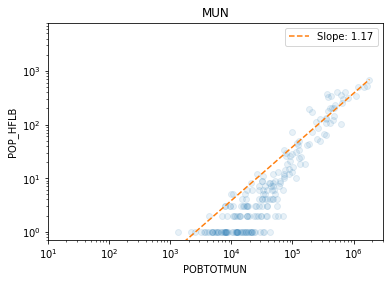

In [ ]:
# The municipality aggregation level
mobilkit.viz.plot_pop(urban_areas_mun_gdf, "MUN")
plt.xlim(1e1,3e6)
plt.ylim(7e-1,8e3)

## Displacement measures

Now we show how to measure the location of users in time.

We have to tell how many initial days to use to determine the original home location.

Then, we tell how many days to use for each window to determine the dynamical home location of each user (and how many pings we want at least for a night to be valid).

In [28]:
# The parameters of the home location in window function
initial_days_home = 2
home_days_window = 2
start_date=None

# Compute running home location
running_home_df = mobilkit.temporal.homeLocationWindow(dd_week_hw,
                    initial_days_home=initial_days_home,
                    home_days_window=home_days_window,
                    start_date=None, stop_date=None)

Got the delta days distributed as: count    29331.000000
mean         3.639324
std          2.024058
min          0.000000
25%          2.000000
50%          4.000000
75%          5.000000
max          7.000000
Name: deltaDay, dtype: float64
Doing window 01 / 02
Doing window 02 / 02


In [29]:
# We now have for ech user and time window (with its initial date) the location
# where he supposedly spent the night and how many pings are recorded there
running_home_df.head(4)

,pings,tile_ID,timeSlice,uid,window_date
0,9,106,0,1,2020-06-01 00:00:00+00:00
1,273,106,0,2,2020-06-01 00:00:00+00:00
2,314,106,0,4,2020-06-01 00:00:00+00:00
3,212,106,0,7,2020-06-01 00:00:00+00:00


After we determined the residing area for each user/night we use `mobilkit.temporal.computeDisplacementFigures` to get four objects containing the results of the analysis.

The ones we are interested in are:
- `pivoted_df` telling for each night where a user slept;
- `count_users_per_area` telling for each area how many users originally residing there were active and how many were displaced on that day;

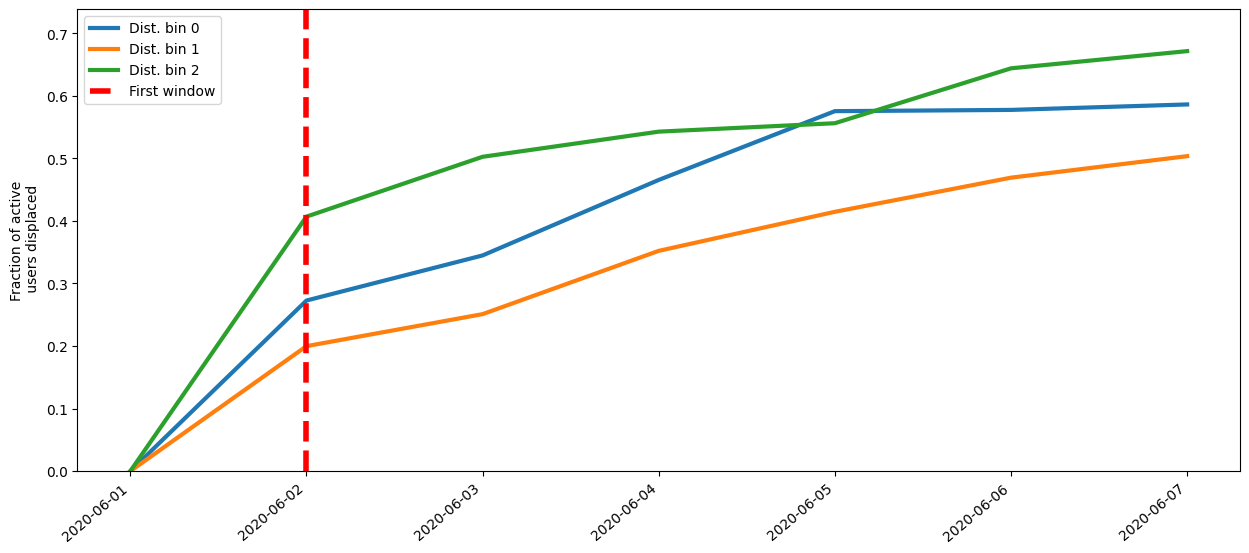

In [30]:
# Compute displacement figures

minimum_pings_per_night = 3

pivoted_df, original_home,\
    heaps, count_users_per_area = mobilkit.temporal.computeDisplacementFigures(
        running_home_df, minimum_pings_per_night=minimum_pings_per_night,
)

# The lat lon of the center
epicenter = [tessellation_gdf.unary_union.centroid.xy[1][0], 
             tessellation_gdf.unary_union.centroid.xy[0][0]]

# Assess displacement based on distance from epicenter
fig, gdf_enriched = mobilkit.temporal.plotDisplacement(count_users_per_area, pivoted_df,
                                   tessellation_gdf,
                                   epicenter=epicenter,
                                   bins=3)

<Axes: >

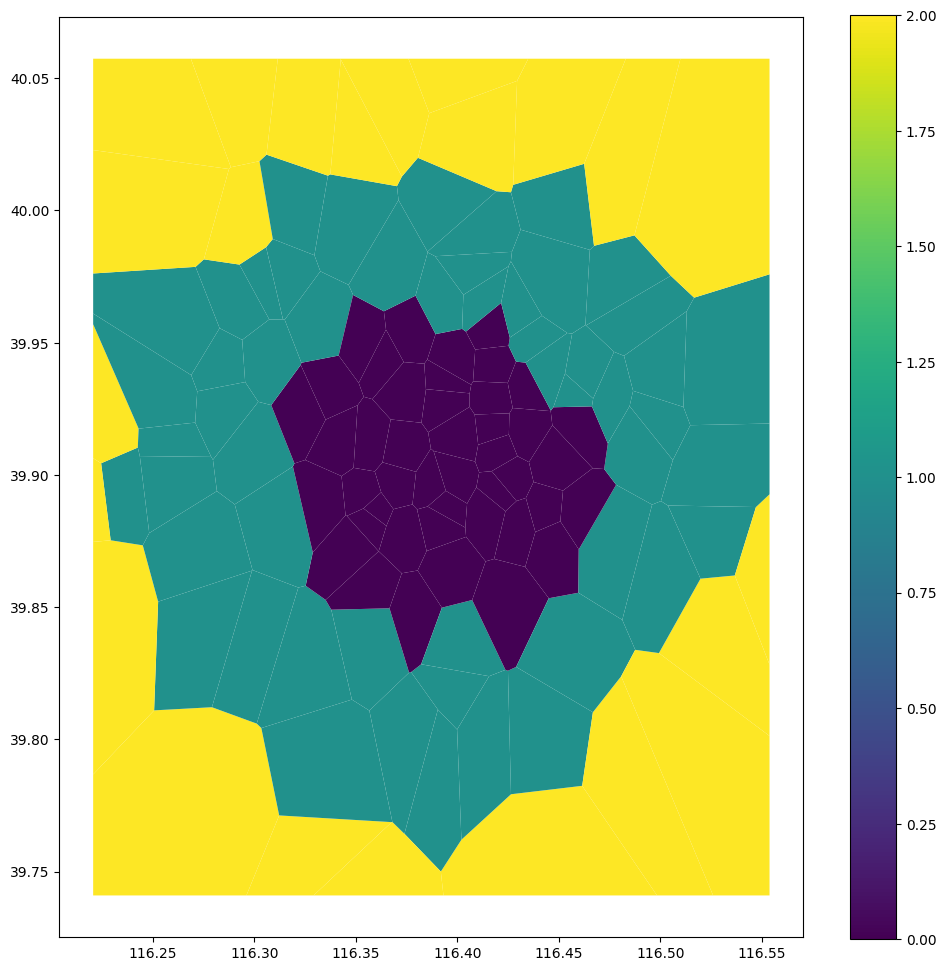

In [31]:
# Viusualize the distance bins
fig, ax = plt.subplots(1,1,figsize=(12,12))
ax.set_aspect("equal")
gdf_enriched.plot("distance_bin", legend=True, ax=ax)

Text(0.5, 1.0, 'Date = 03/06/2020')

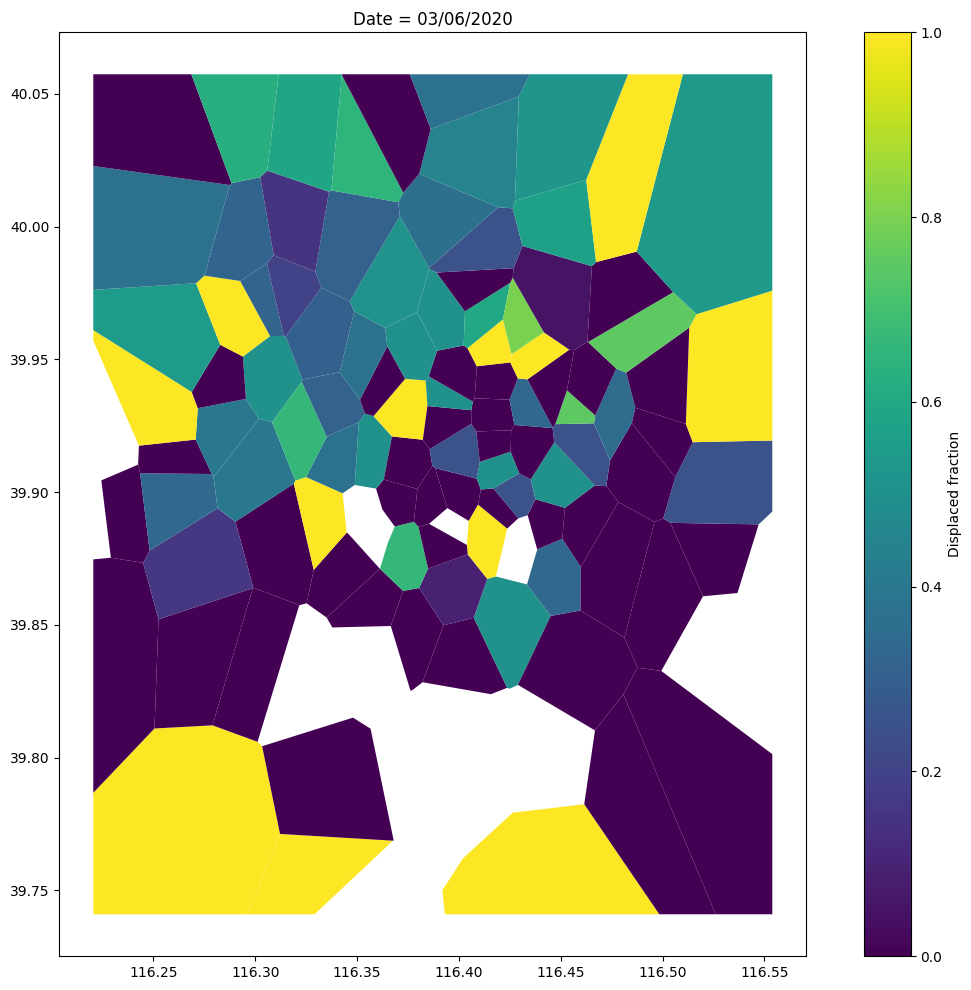

In [32]:
# Visualize the displacement rate per area on a given date
dates_sorted = sorted(pivoted_df.columns)
selected_date_index = 2

gdf_enriched["displaced_at_date"] = gdf_enriched["tile_ID"].apply(lambda a: 
                                                      count_users_per_area[a]["displaced"][selected_date_index]
                                                      / max(1, count_users_per_area[a]["active"][selected_date_index])
                                                      if a in count_users_per_area else None)

fig, ax = plt.subplots(1,1,figsize=(15,12))
ax.set_aspect("equal")
gdf_enriched.plot("displaced_at_date", legend=True, ax=ax, legend_kwds={'label': "Displaced fraction"})
plt.title("Date = %s" % dates_sorted[selected_date_index].strftime("%d/%m/%Y"))

## Land use

For this particular analysis we use the daily data because they map to more users (more stats).

We start assigning every ping to a location and then we compute the activity profiles.

In [33]:
dd_usr_with_zones, tessellation_gdf = mobilkit.spatial.tessellate(dd_users_raw,
                                                                  tesselation_shp=voronoi_file,
                                                                  filterAreas=True)
dd_usr_with_zones.head()

,UTC,acc,datetime,lat,lng,uid,tile_ID
0,1591008784,1,2020-06-01 10:53:04+00:00,39.984702,116.318417,0,99
1,1591008790,1,2020-06-01 10:53:10+00:00,39.984683,116.318450,0,99
2,1591008795,1,2020-06-01 10:53:15+00:00,39.984686,116.318417,0,99
3,1591008800,1,2020-06-01 10:53:20+00:00,39.984688,116.318385,0,99
4,1591008805,1,2020-06-01 10:53:25+00:00,39.984655,116.318263,0,99


In [34]:
# This is the time period over which we want to compute the average activity of an area
# normalization="total" tells to the program to normalize the activity of each area dividing it by
# the overall volume of pings or users found in all the ROI. See the docs for other normalization
# strategies.
selected_profile_period = "day"
total_profiles_df = mobilkit.temporal.computeTemporalProfile(dd_usr_with_zones, timeBin="H",
                                                             byArea=True, 
                                                             profile=selected_profile_period,
                                                            normalization="total").compute()

In [35]:
# We compute the residual activity of users found in a given area
signal_column = "users"
results, mappings =  mobilkit.temporal.computeResiduals(total_profiles_df,
            signal_column=signal_column, profile=selected_profile_period)

Finally we try to cluster these profiles in some groups.
We use hierarchical clustering of the residual activity profiles using the cosine metric.

This plot tells us the score of the partitioning, the higer the better.

Given that we do not have many data we select `n=4` clusters even though we do not have a clear maximum.

Done n clusters = 02
Done n clusters = 03
Done n clusters = 04
Done n clusters = 05
Done n clusters = 06
Done n clusters = 07
Done n clusters = 08
Done n clusters = 09
Done n clusters = 10


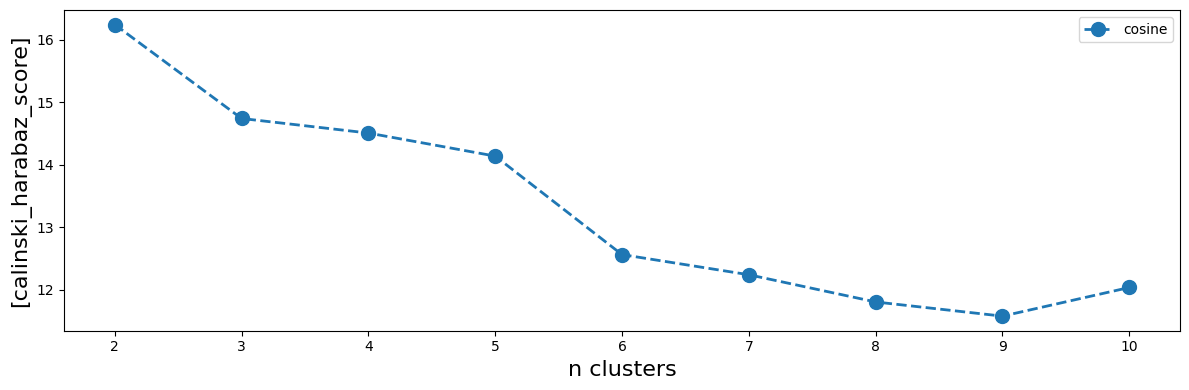

In [36]:
signal_to_use = "residual"
metric = "cosine"  # The metric to be used in computing the distance matrix
results_clusters = mobilkit.tools.computeClusters(results,
                                                  signal_to_use,
                                                  metric=metric,
                                                  nClusters=range(2,11))

# Visualize score
ax_score = mobilkit.tools.checkScore(results_clusters)

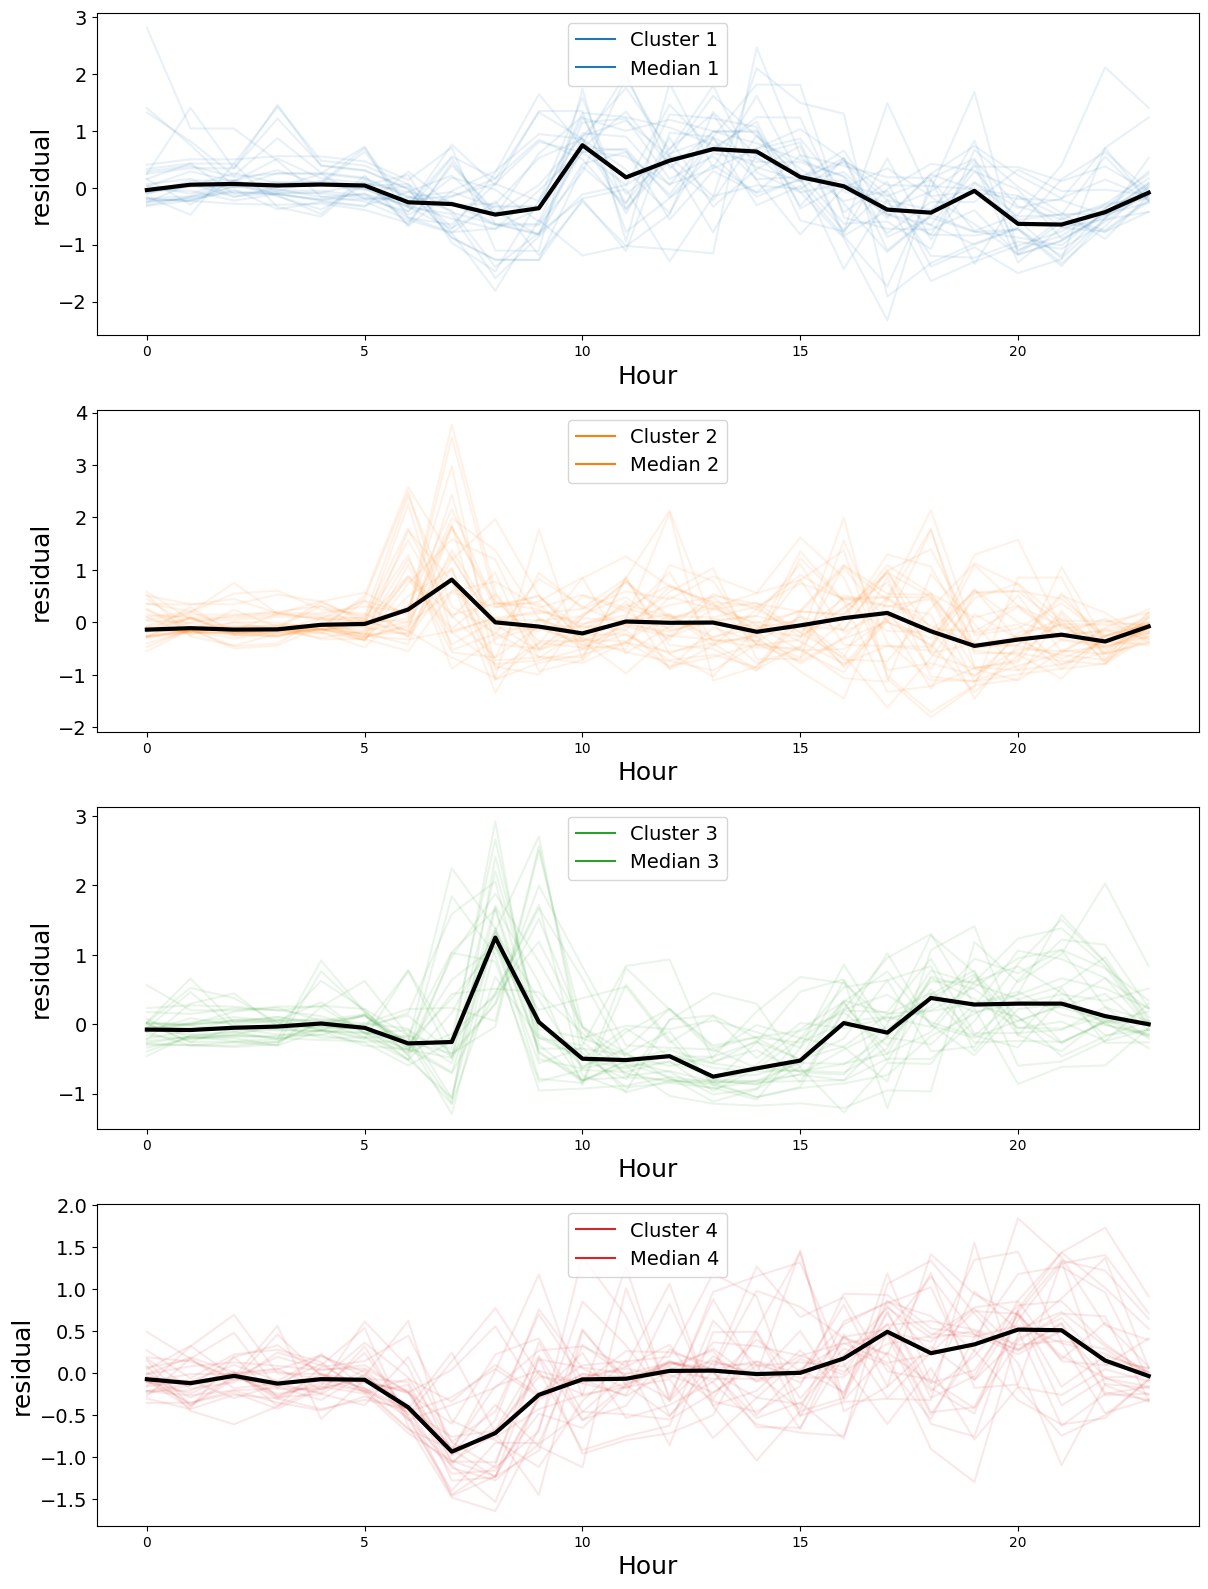

In [37]:
# Plot clusters profiles and map: We select 4 clusters and plot their profiles and map.
nClusters = 4
ax = mobilkit.tools.visualizeClustersProfiles(results_clusters,
            nClusts=nClusters, showMean=False, showMedian=True, showCurves=True)

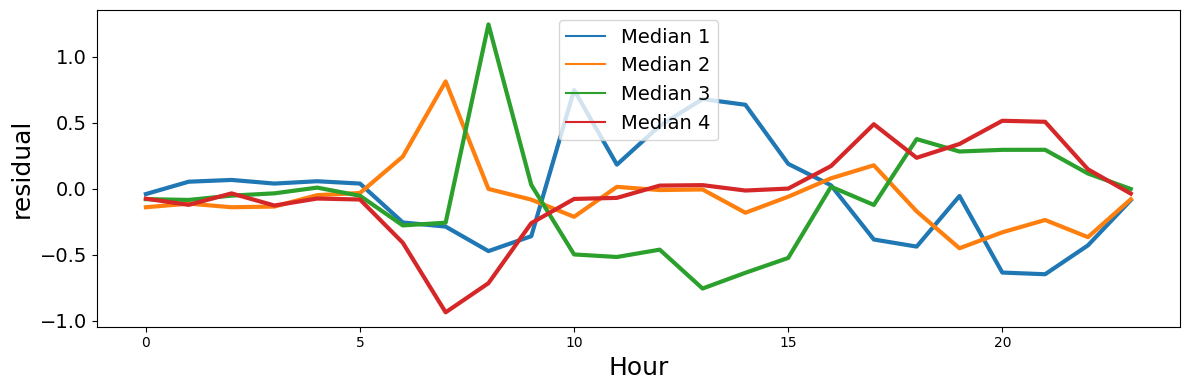

In [38]:
# We compare all the medians activity profiles of the 4 clusters
ax = mobilkit.tools.visualizeClustersProfiles(results_clusters,
            nClusts=nClusters, showMean=False, showMedian=True, showCurves=False, together=True)

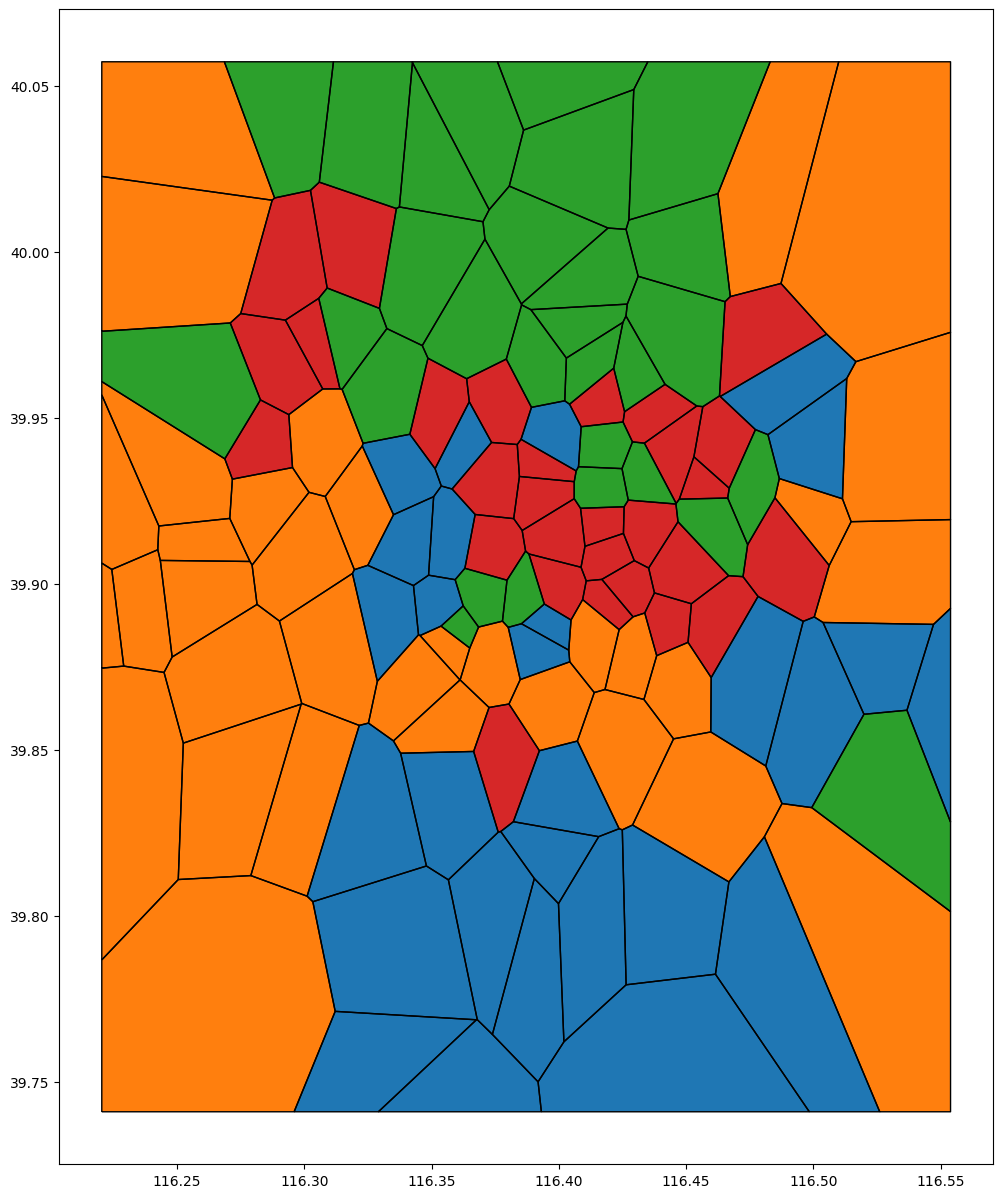

In [39]:
# We plot the map of the clusters, with the same colors as before.
gdf_update, ax_mappa = mobilkit.tools.plotClustersMap(tessellation_gdf, results_clusters,
                                                      mappings, nClusts=nClusters)